## **Introduction**

**The Pixel War** of this year unfolded on Reddit, spanning from the 20th to the 25th of July 2023.

Although no dataset was officially released, there's an exciting development! Following the end of the Pixel War, Reddit introduced a feature called "View Canvas History" which allows users to visualize what happened during those eventful days.

**The purpose of this notebook** is to conduct an in-depth analysis of the API responsible for serving the "View Canvas History" feature, with the ultimate goal of **extracting and gathering valuable data from it**.

Then we will try to generate a **timelaps video**

**Here is what the feature "View Canvas History" looks like**

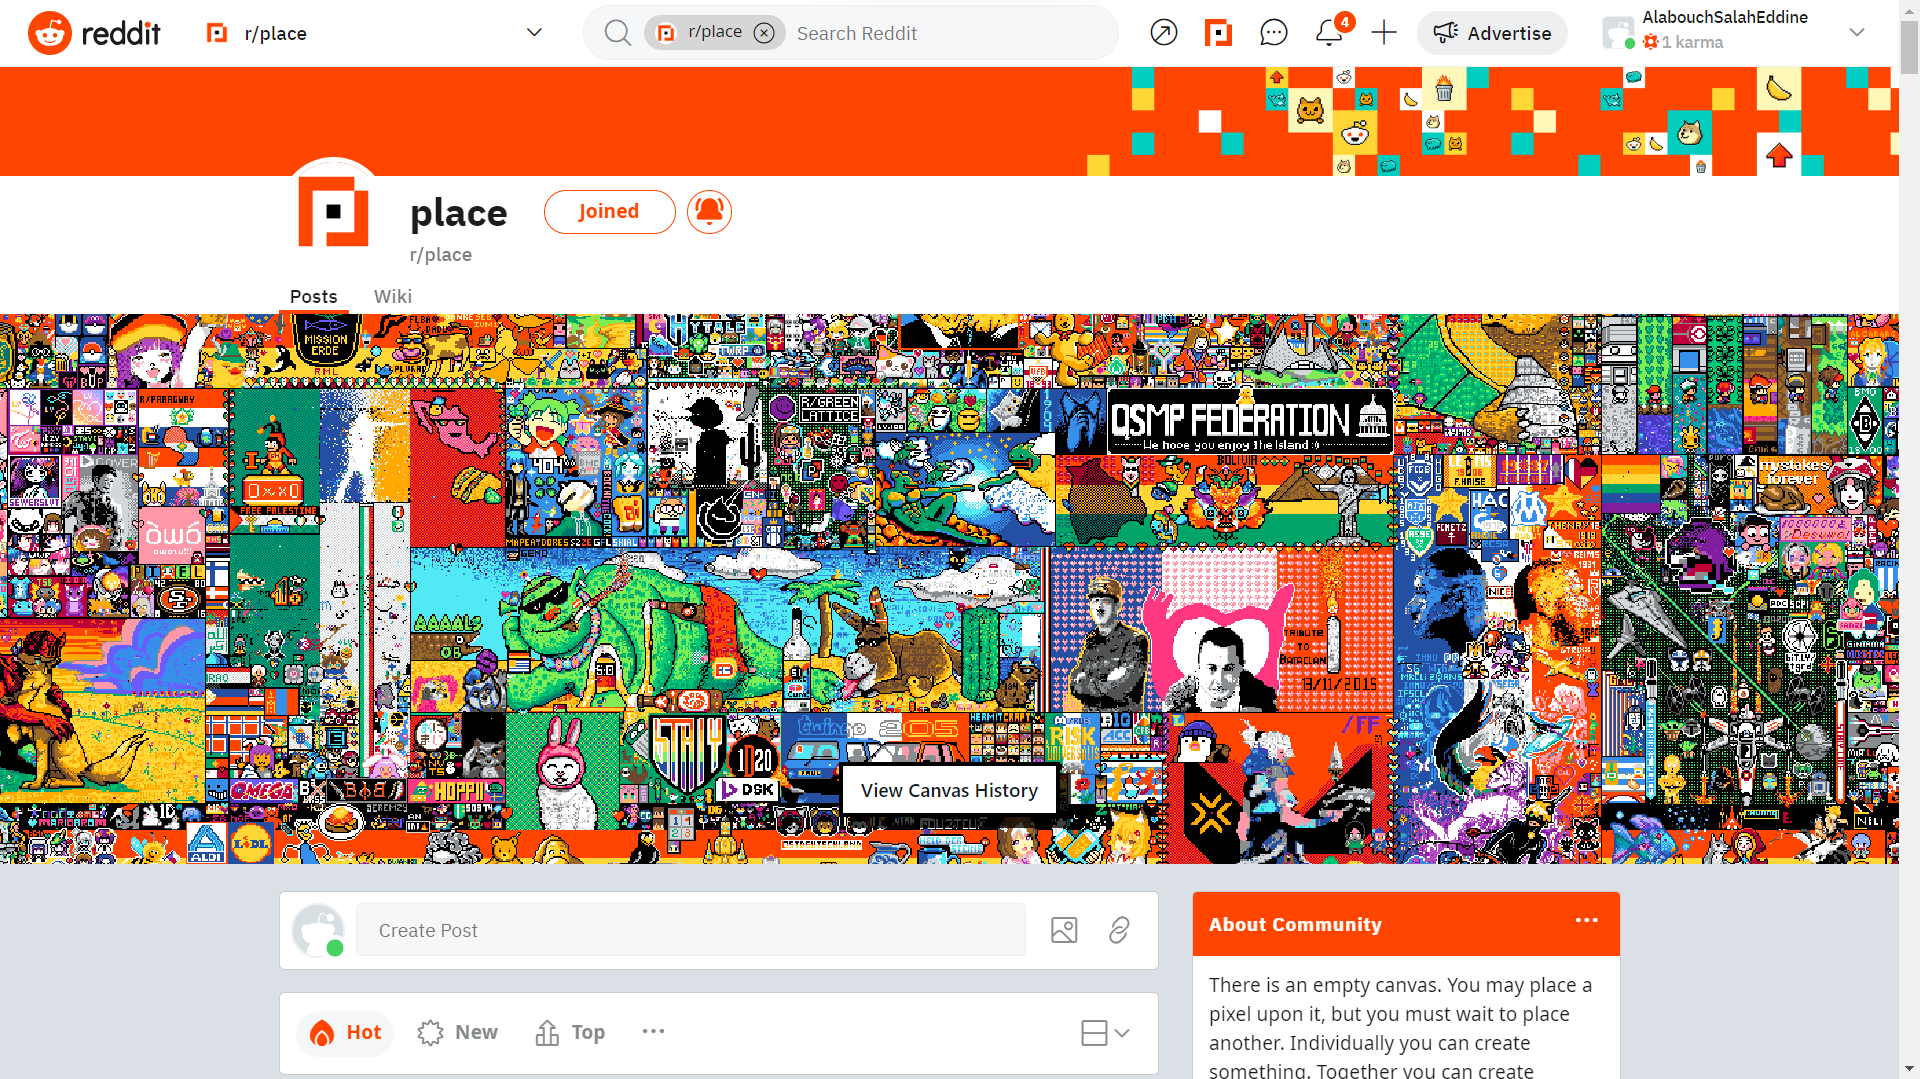

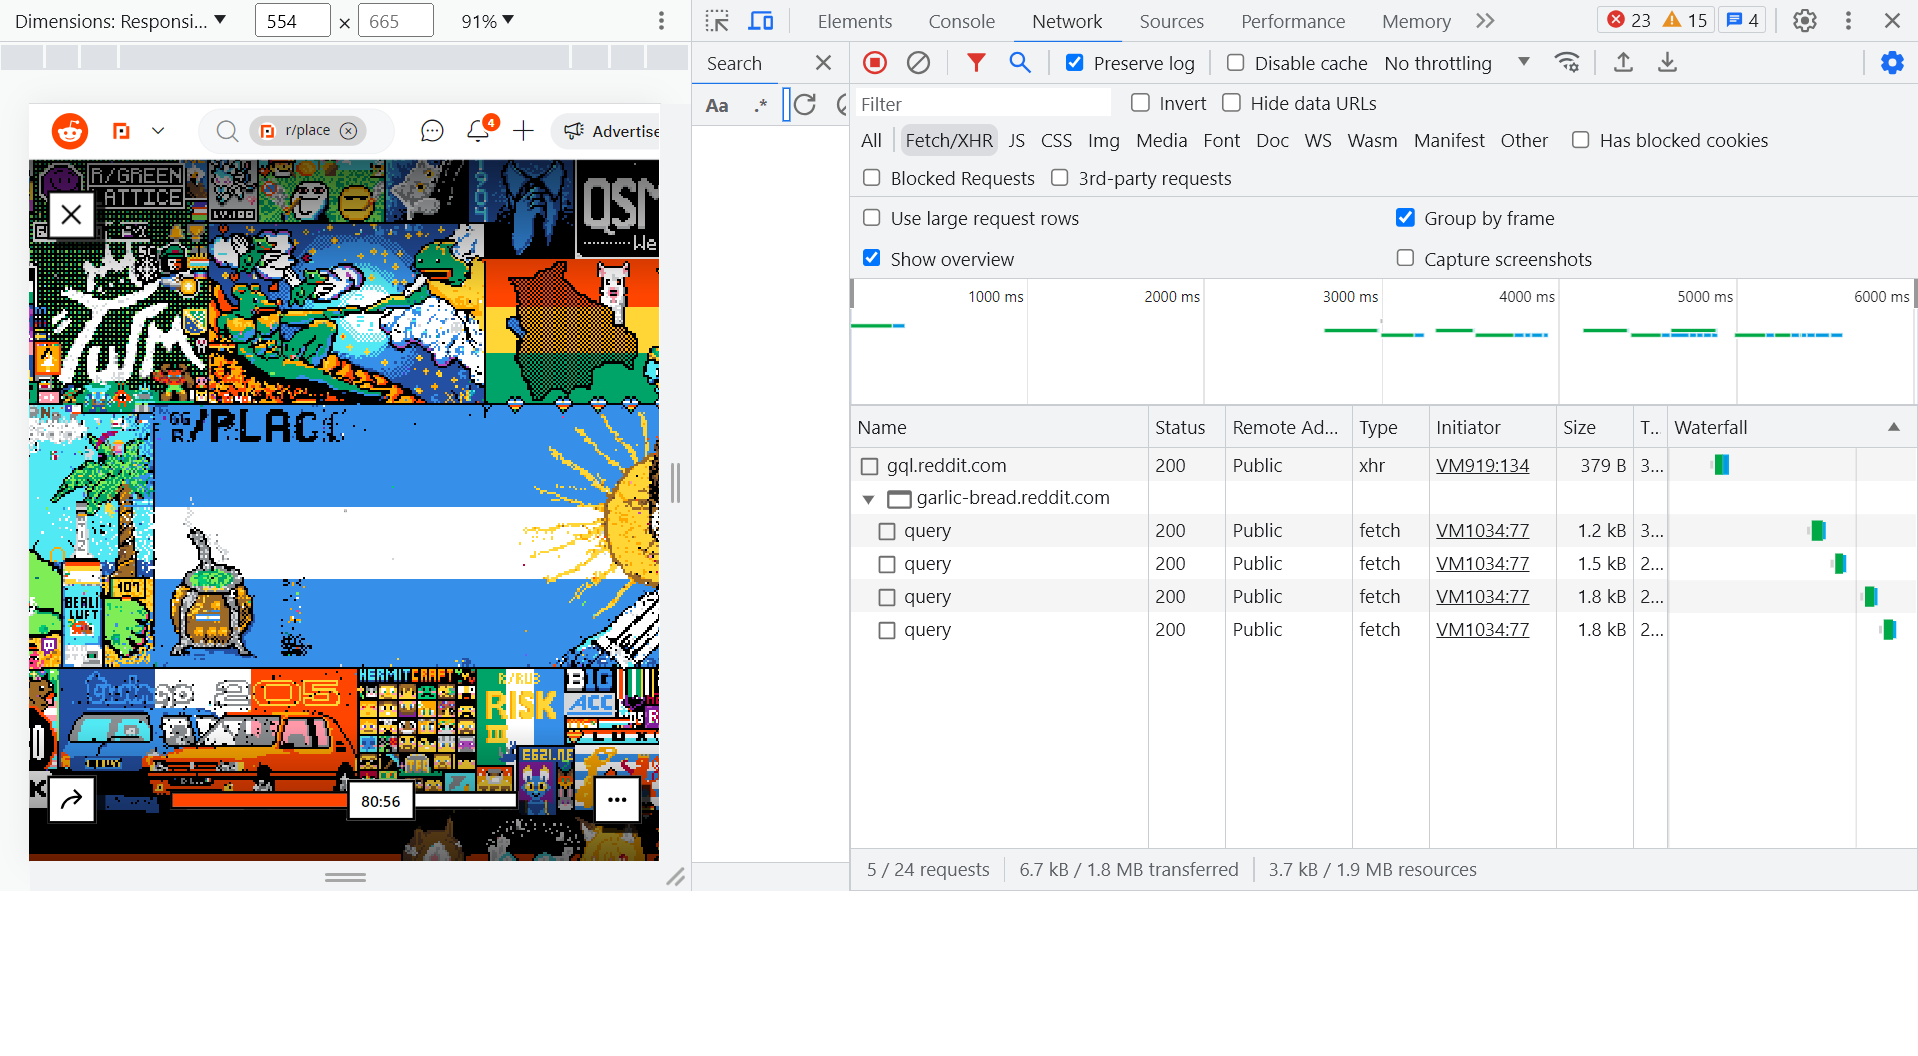

Using the time advancement feature, one can observe that there are API requests being sent.

Thus, we can extract these requests to be able to replicate them in code and analyze the JSON served by the API in response to the request.

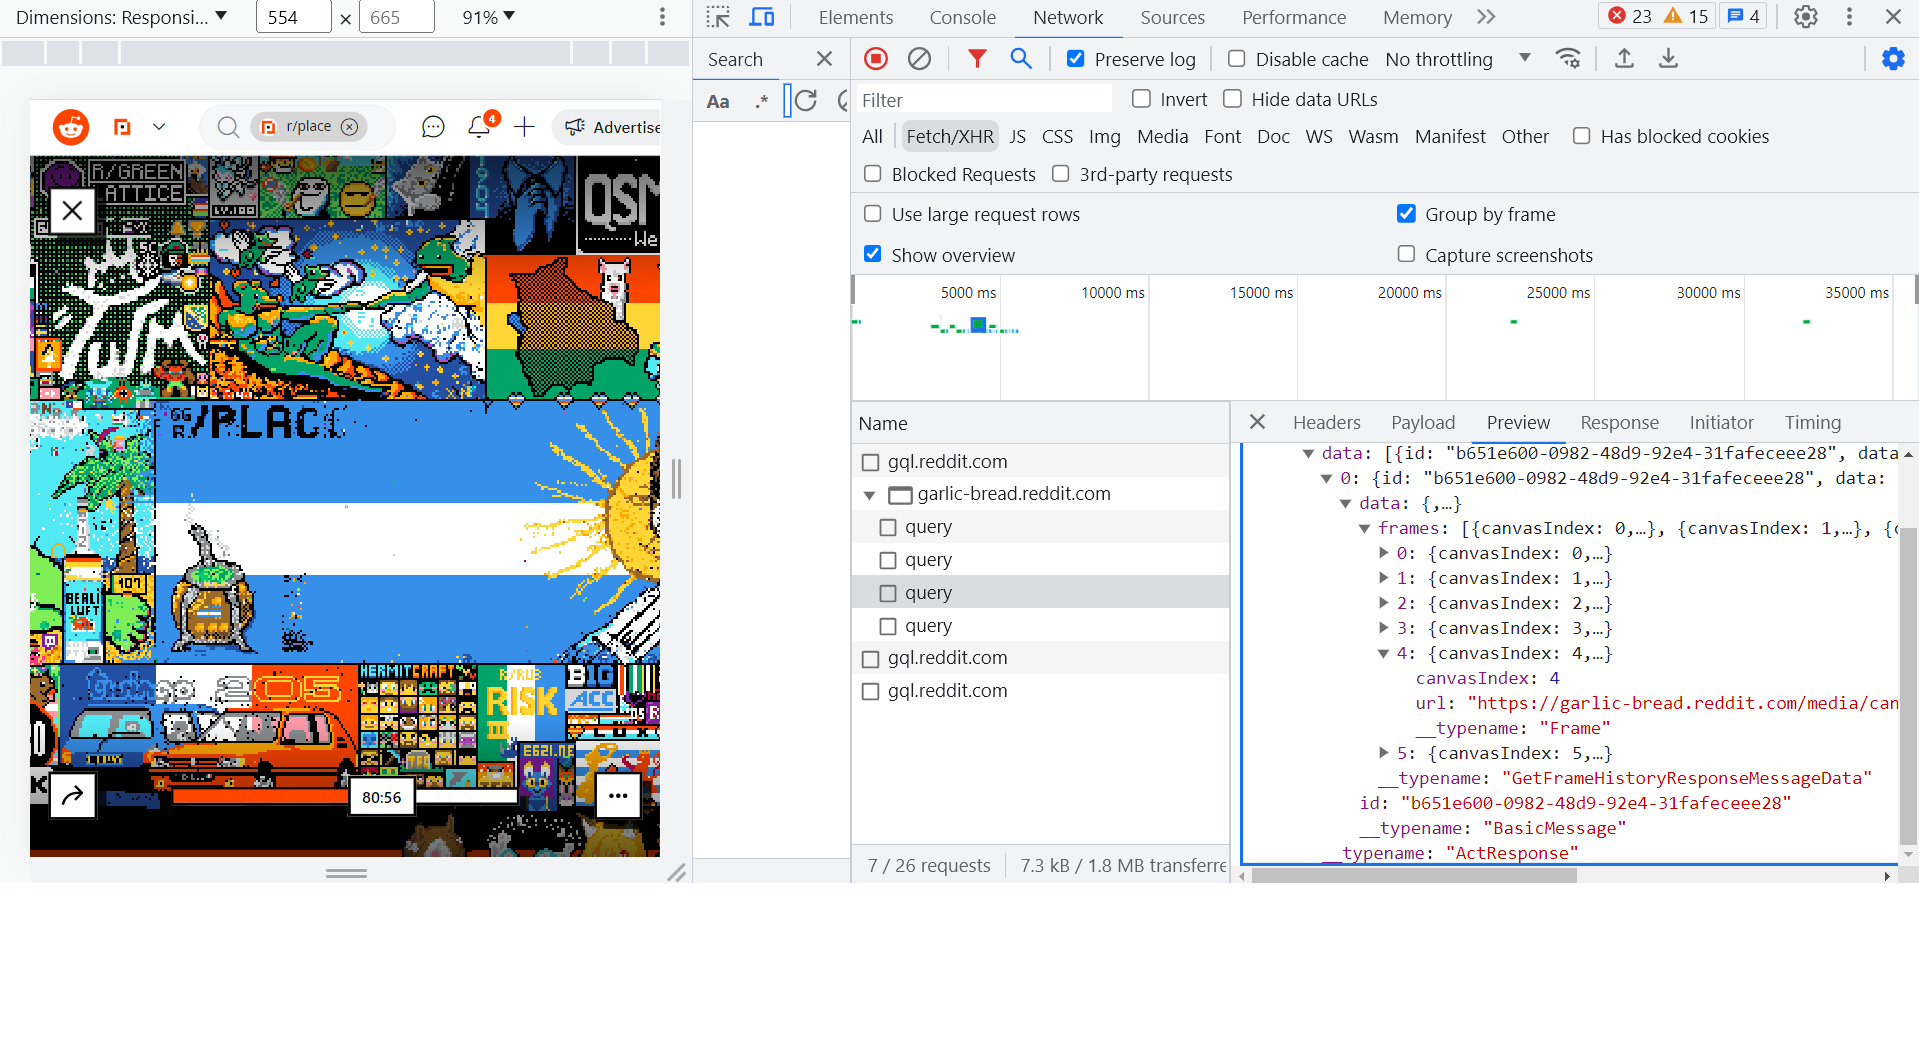

By placing the cursor at the start and end points, we can obtain the timestamps for the beginning and end of the Pixel War 2023.

The two timestamps are:

1689858257 <==> **GMT:** Thursday 20 July 2023 13:04:17

1690320892 <==> **GMT:** Tuesday 25 July 2023 21:34:52

## **Collecting data**

The following code has been developed to request the API, which returns a JSON containing canvas frames.
Each frame in the JSON includes a link to the PNG image of the frame of the state of the Pixel war corresponding to each timestamp.

In [ ]:
import requests
import json
import shutil
import os

def delete_directory(directory_path):
    try:
        # Delete the directory and all its contents
        shutil.rmtree(directory_path)
        print(f"Directory '{directory_path}' and its contents deleted successfully.")
    except OSError as e:
        print(f"Error deleting the directory: {e}")
def create_directory(directory_path):
    try:
        # Create the directory if it doesn't exist
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created successfully.")
    except OSError as e:
        print(f"Error creating the directory: {e}")



def download_png_image(url, save_path):
    try:
        # Send a GET request to fetch the image data
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception if there's an error in the request

        # Check if the response content type is 'image/png'
        if 'image/png' in response.headers.get('content-type', ''):
            # Save the image to the specified path
            with open(save_path, 'wb') as f:
                f.write(response.content)

        else:
            print("The provided URL does not point to a PNG image.")
    except requests.exceptions.RequestException as e:
        print("Error downloading the image:", e)

def downloadImageAtTimestamp(timestamp) :
  url = 'https://gql-realtime-2.reddit.com/query'
  headers = {
    "accept": "*/*",
    "accept-language": "fr,en-US;q=0.9,en;q=0.8,ar;q=0.7,fr-FR;q=0.6,ar-MA;q=0.5",
    "apollographql-client-name": "garlic-bread",
    "apollographql-client-version": "0.0.1",
    "authorization": "Bearer YOUR AUTHORIZATION TOKEN HERE",
    "content-type": "application/json",
    "sec-ch-ua": "\"Not.A/Brand\";v=\"8\", \"Chromium\";v=\"114\", \"Google Chrome\";v=\"114\"",
    "sec-ch-ua-mobile": "?1",
    "sec-ch-ua-platform": "\"Android\"",
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-site",
    "Referer": "https://garlic-bread.reddit.com/",
    "Referrer-Policy": "strict-origin-when-cross-origin"
  }
  payload = "{\"operationName\":\"frameHistory\",\"variables\":{\"input\":{\"actionName\":\"get_frame_history\",\"GetFrameHistoryMessageData\":{\"timestamp\":"+str(timestamp)+"000}}},\"query\":\"mutation frameHistory($input: ActInput!) {\\n  act(input: $input) {\\n    data {\\n      ... on BasicMessage {\\n        id\\n        data {\\n          ... on GetFrameHistoryResponseMessageData {\\n            frames {\\n              canvasIndex\\n              url\\n              __typename\\n            }\\n            __typename\\n          }\\n          __typename\\n        }\\n        __typename\\n      }\\n      __typename\\n    }\\n    __typename\\n  }\\n}\\n\"}"

  response = requests.post(url, headers = headers, data = payload)
  #print(response.text)
  responseText = response.text
  responseJson = json.loads(responseText)
  frames = responseJson["data"]["act"]["data"][0]["data"]["frames"]
  try :
    for frame in frames :
      canvasIndex = frame["canvasIndex"]
      imageUrl = frame["url"]
      #print(imageUrl)
      download_png_image(imageUrl, "images/canvasIndex_"+str(canvasIndex) + "_" +str(timestamp)+".png")
  except json.decoder.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}. Skipping timestamp: {timestamp}")
def downloadAllImagesBetweenTimestamps(beginningTimestamp, endTimestamp) :
  j=0
  for i in range(beginningTimestamp, endTimestamp+1, 60):
    downloadImageAtTimestamp(i)
    j += 1
    if j % 60 == 0 :
      print(i)
      j=0

delete_directory("images")
create_directory("images")
downloadAllImagesBetweenTimestamps(1690078457, 1689859999)

Directory 'images' and its contents deleted successfully.
Directory 'images' created successfully.


To quickly download the images from my AWS EC2 instance, I had to zip them. Here is the code used to zip the images.

In [ ]:
import os
import zipfile

def create_zip_files(directory_path, files_per_zip):
    # Get the list of all files in the directory
    all_files = os.listdir(directory_path)
    total_files = len(all_files)

    # Calculate the number of zip files needed and the number of files in the last zip
    num_zip_files = total_files // files_per_zip
    remaining_files = total_files % files_per_zip

    # Create the directory to store the zip files
    if not os.path.exists('zip_files'):
        os.mkdir('zip_files')

    # Create the zip files
    for i in range(num_zip_files):
        start_index = i * files_per_zip
        end_index = (i + 1) * files_per_zip
        zip_filename = f'zip_files/zip_{i + 1}.zip'

        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zip_file:
            for file in all_files[start_index:end_index]:
                file_path = os.path.join(directory_path, file)
                zip_file.write(file_path, os.path.basename(file_path))

    # Create the last zip file with the remaining files
    if remaining_files > 0:
        start_index = num_zip_files * files_per_zip
        zip_filename = f'zip_files/zip_{num_zip_files + 1}.zip'

        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zip_file:
            for file in all_files[start_index:]:
                file_path = os.path.join(directory_path, file)
                zip_file.write(file_path, os.path.basename(file_path))

if __name__ == '__main__':
    directory_path = 'images/'  # Replace this with your actual directory path
    files_per_zip = 2000

    create_zip_files(directory_path, files_per_zip)


After extracting all the zip files into a single folder named "all_images," I had to reconstruct the large image composed of the 6 canvases. The Pixel War initially started with 2 canvases, and then Reddit gradually added empty canvases to allow more people to draw.

Here is the code to recombine the image from the - canvas from each timestamp.

For an unkonwn reason, I had some missing canvas, so I had to handle that.

## **Recombing images**

In [ ]:
from PIL import Image

def combine_images_vertically(images):
    widths, heights = zip(*(img.size for img in images))
    total_width = max(widths)
    total_height = sum(heights)
    new_image = Image.new('RGB', (total_width, total_height))
    y_offset = 0
    for img in images:
        new_image.paste(img, (0, y_offset))
        y_offset += img.size[1]
    return new_image

def combine_images_horizontally(images):
    widths, heights = zip(*(img.size for img in images))
    total_width = sum(widths)
    total_height = max(heights)
    new_image = Image.new('RGB', (total_width, total_height))
    x_offset = 0
    for img in images:
        new_image.paste(img, (x_offset, 0))
        x_offset += img.size[0]

# Your combine_images_vertically and combine_images_horizontally functions remain unchanged.
width = 1000
height = 1000
folder_path = "all_images/"

for i in range(1689983597, 1690320892, 60):
    image0 = folder_path + "canvasIndex_0_" + str(i) + ".png"
    image1 = folder_path + "canvasIndex_1_" + str(i) + ".png"
    image2 = folder_path + "canvasIndex_2_" + str(i) + ".png"
    image3 = folder_path + "canvasIndex_3_" + str(i) + ".png"
    image4 = folder_path + "canvasIndex_4_" + str(i) + ".png"
    image5 = folder_path + "canvasIndex_5_" + str(i) + ".png"

    # Check if canvasIndex_0, canvasIndex_2, canvasIndex_3, and canvasIndex_5 exist. If not, use blank images.
    img0 = Image.open(image0) if os.path.exists(image0) else Image.new('RGB', (width, height), color='white')
    img1 = Image.open(image1) if os.path.exists(image1) else None
    img2 = Image.open(image2) if os.path.exists(image2) else Image.new('RGB', (width, height), color='white')
    img3 = Image.open(image3) if os.path.exists(image3) else Image.new('RGB', (width, height), color='white')
    img4 = Image.open(image4) if os.path.exists(image4) else None
    img5 = Image.open(image5) if os.path.exists(image5) else Image.new('RGB', (width, height), color='white')

    # Check if both canvasIndex_1 and canvasIndex_4 are missing. If so, skip to the next iteration.
    if img1 is None or img4 is None:
        continue

    # Combine the images vertically
    top_row = combine_images_horizontally([img0, img1, img2])
    bottom_row = combine_images_horizontally([img3, img4, img5])

    # Combine the two rows
    final_image = combine_images_vertically([top_row, bottom_row])

    # Save the final image
    final_image.save('all_images_combined/combined_image_' + str(i) + '.png')

## **Generating the timelaps**

In [ ]:
import cv2
import numpy as np
import glob



img_array = []
allImages = glob.glob('all_images_combined/*.png')
allImagesSorted = sorted(allImages)


for filename in allImagesSorted:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 50, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()